In [1]:
from openmmtools.testsystems import WaterCluster
testsystem = WaterCluster(restrain_only_oxygen=True)

import numpy as np
import openmmtools
from openmmtools.constants import kB
from simtk import openmm as mm
from simtk.openmm import app
from tqdm import tqdm

# Versions helpful for debugging
print('openmmtools version: {}'.format(openmmtools.version.full_version))
print('openmm version: {}'.format(mm.version.full_version))

# Set some global variables
from simtk import unit
temperature = 298 * unit.kelvin
beta = 1.0 / (kB * temperature)

timestep = 2.0 * unit.femtosecond
temperature = 298 * unit.kelvin

integrator = openmmtools.integrators.BAOABIntegrator(
        measure_heat=False,
        measure_shadow_work=False,
        collision_rate=1.0 / unit.picoseconds,
        timestep=timestep,
        temperature=temperature,
    )

sim = app.Simulation(testsystem.topology, testsystem.system, integrator,
                 platform=mm.Platform.getPlatformByName("Reference"))

openmmtools version: 0.15.0
openmm version: 7.2.1.dev-f9106dd


In [2]:
sim.context.setPositions(testsystem.positions)
sim.context.setVelocitiesToTemperature(temperature)

In [3]:
%%time
sim.step(1)

CPU times: user 14.2 ms, sys: 2.65 ms, total: 16.8 ms
Wall time: 15.7 ms


In [4]:
%%time
sim.step(1)

CPU times: user 2.71 ms, sys: 1.54 ms, total: 4.24 ms
Wall time: 2.47 ms


In [5]:
sim.step(1000)

In [6]:
from tqdm import tqdm
samples = []
for _ in tqdm(range(1000)):
    sim.step(100)
    samples.append(sim.context.getState(getPositions=True).getPositions(asNumpy=True))

100%|██████████| 1000/1000 [02:33<00:00,  6.50it/s]


In [7]:
samples[0].std(0), samples[-1].std(0)

(Quantity(value=array([0.306946348673449, 0.269502626802728, 0.222100126333969]), unit=nanometer),
 Quantity(value=array([0.257176501095705, 0.818228066344383, 0.580124631686767]), unit=nanometer))

In [8]:
sample_cache = samples

In [9]:
from openmmtools.alchemy import AlchemicalRegion, AbsoluteAlchemicalFactory
region = AlchemicalRegion(alchemical_atoms=range(3))
factory = AbsoluteAlchemicalFactory()
alchemical_system = factory.create_alchemical_system(testsystem.system, region)
testsystem.system = alchemical_system

```
The context parameters created are:
 |  - softcore_alpha: factor controlling softcore lengthscale for Lennard-Jones
 |  - softcore_beta: factor controlling softcore lengthscale for Coulomb
 |  - softcore_a: softcore Lennard-Jones parameter from Eq. 13 of Ref [1]
 |  - softcore_b: softcore Lennard-Jones parameter from Eq. 13 of Ref [1]
 |  - softcore_c: softcore Lennard-Jones parameter from Eq. 13 of Ref [1]
 |  - softcore_d: softcore electrostatics parameter
 |  - softcore_e: softcore electrostatics parameter
 |  - softcore_f: softcore electrostatics parameter```

In [10]:
#n_samples = 1000
n_samples = 100

## Use pre-generated samples from the 298K ensemble with HBonds constrained
#import mdtraj as md
#samples = md.load('water_cluster_constrained_samples.h5')
#sample_cache = samples.xyz * unit.nanometer

# Define what will be variable during the experiments
splittings = {'VVVR (OVR-H-RVO)': 'O V R H R V O',
              'BAOAB-mid (VRO-H-RV)': 'V R O H R V',
              'BAOAB-end (VRORV-H)': 'V R O R V H',
              # 'velocity-verlet-mid (VR-H-RV)': 'V R H R V', # requires to disable LangevinIntegrator splitting checks
              # 'velocity-verlet-end (VRV-H)': 'V R V H', # requires to disable LangevinIntegrator splitting checks
              }


from collections import namedtuple
Condition = namedtuple('Condition', ['timestep', 'switching_time', 'n_switching_steps', 'splitting'])

def collect_samples_at_condition(condition):
    print(condition)

    timestep = condition.timestep
    n_switching_steps = condition.n_switching_steps
    splitting = splittings[condition.splitting]

    integrator = openmmtools.integrators.AlchemicalNonequilibriumLangevinIntegrator(
        alchemical_functions={'lambda_electrostatics': '1-lambda',
                              'lambda_sterics': '1-lambda'
                             },
        splitting=splitting,
        measure_heat=True,
        measure_shadow_work=False,
        nsteps_neq=n_switching_steps,
        collision_rate=1.0 / unit.picoseconds,
        timestep=timestep,
        temperature=temperature,
    )

    sim = app.Simulation(testsystem.topology, testsystem.system, integrator,
                         platform=mm.Platform.getPlatformByName("Reference"))

    # store in reduced units...
    w_shads = np.zeros(n_samples)
    w_prots = np.zeros(n_samples)
    w_tots = np.zeros(n_samples)
    reduced_DeltaEs = np.zeros(n_samples)

    for i in tqdm(range(n_samples + 1)):
        if i > 1: i -= 1 # discard first sample

        # set initial (x,v) from equilibrium
        x0 = sample_cache[np.random.randint(len(sample_cache))]
        sim.context.setPositions(x0)
        sim.context.setVelocitiesToTemperature(temperature)

        # reset the relevant integrator state
        sim.integrator.reset()
        sim.integrator.setGlobalVariableByName('lambda', 0)
        sim.integrator.setGlobalVariableByName('lambda_step', 0)

        # get the total energy before switching
        state_0 = sim.context.getState(getEnergy=True)
        E_0 = state_0.getPotentialEnergy() + state_0.getKineticEnergy()

        # perform switching
        sim.step(n_switching_steps)

        # get the total energy change
        state_1 = sim.context.getState(getEnergy=True)
        E_1 = state_1.getPotentialEnergy() + state_1.getKineticEnergy()
        DeltaE = (E_1 - E_0)
        reduced_DeltaEs[i] = beta * DeltaE

        # get the heat and protocol work, derive total work, shadow work
        W_prot = integrator.get_protocol_work()
        w_prots[i] = beta * W_prot

        Q = integrator.get_heat()

        w_tots[i] = beta * (DeltaE - Q + W_prot)
        w_shads[i] = w_tots[i] - w_prots[i]

    result = {'w_shads': w_shads,
              'w_tots': w_tots,
              'w_prots': w_prots,
              'reduced_DeltaEs': reduced_DeltaEs
              }
    return result


def save_result(experiment_id, condition, result):
    from pickle import dump
    fname = str(experiment_id) + '.pkl'
    with open(fname, 'wb') as f:
        dump({'condition': condition, 'result': result}, f)

In [11]:
switching_time = 1.0 * unit.picosecond
timesteps = np.array([0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0]) * unit.femtosecond
conditions = []
for timestep in timesteps:
    n_switching_steps = int(switching_time / timestep)

    condition = Condition(timestep=timestep,
                    switching_time=switching_time,
                    n_switching_steps=n_switching_steps,
                    splitting='BAOAB-end (VRORV-H)')
    print(condition)
    conditions.append(condition)

Condition(timestep=Quantity(value=0.5, unit=femtosecond), switching_time=Quantity(value=1.0, unit=picosecond), n_switching_steps=2000, splitting='BAOAB-end (VRORV-H)')
Condition(timestep=Quantity(value=1.0, unit=femtosecond), switching_time=Quantity(value=1.0, unit=picosecond), n_switching_steps=1000, splitting='BAOAB-end (VRORV-H)')
Condition(timestep=Quantity(value=1.5, unit=femtosecond), switching_time=Quantity(value=1.0, unit=picosecond), n_switching_steps=666, splitting='BAOAB-end (VRORV-H)')
Condition(timestep=Quantity(value=2.0, unit=femtosecond), switching_time=Quantity(value=1.0, unit=picosecond), n_switching_steps=500, splitting='BAOAB-end (VRORV-H)')
Condition(timestep=Quantity(value=2.5, unit=femtosecond), switching_time=Quantity(value=1.0, unit=picosecond), n_switching_steps=400, splitting='BAOAB-end (VRORV-H)')
Condition(timestep=Quantity(value=3.0, unit=femtosecond), switching_time=Quantity(value=1.0, unit=picosecond), n_switching_steps=333, splitting='BAOAB-end (VRORV-H

In [13]:
results = []
for experiment_id, condition in enumerate(conditions[::-1]):
    result = collect_samples_at_condition(condition)
    results.append(result)
    save_result(experiment_id=experiment_id, condition=condition, result=result)
results = results[::-1]

  0%|          | 0/101 [00:00<?, ?it/s]

Condition(timestep=Quantity(value=4.0, unit=femtosecond), switching_time=Quantity(value=1.0, unit=picosecond), n_switching_steps=250, splitting='BAOAB-end (VRORV-H)')


  0%|          | 0/101 [00:00<?, ?it/s]

Condition(timestep=Quantity(value=3.5, unit=femtosecond), switching_time=Quantity(value=1.0, unit=picosecond), n_switching_steps=285, splitting='BAOAB-end (VRORV-H)')


  0%|          | 0/101 [00:00<?, ?it/s]

Condition(timestep=Quantity(value=3.0, unit=femtosecond), switching_time=Quantity(value=1.0, unit=picosecond), n_switching_steps=333, splitting='BAOAB-end (VRORV-H)')


  0%|          | 0/101 [00:00<?, ?it/s]

Condition(timestep=Quantity(value=2.5, unit=femtosecond), switching_time=Quantity(value=1.0, unit=picosecond), n_switching_steps=400, splitting='BAOAB-end (VRORV-H)')


  0%|          | 0/101 [00:00<?, ?it/s]

Condition(timestep=Quantity(value=2.0, unit=femtosecond), switching_time=Quantity(value=1.0, unit=picosecond), n_switching_steps=500, splitting='BAOAB-end (VRORV-H)')


  0%|          | 0/101 [00:00<?, ?it/s]

Condition(timestep=Quantity(value=1.5, unit=femtosecond), switching_time=Quantity(value=1.0, unit=picosecond), n_switching_steps=666, splitting='BAOAB-end (VRORV-H)')


  0%|          | 0/101 [00:00<?, ?it/s]

Condition(timestep=Quantity(value=1.0, unit=femtosecond), switching_time=Quantity(value=1.0, unit=picosecond), n_switching_steps=1000, splitting='BAOAB-end (VRORV-H)')


  0%|          | 0/101 [00:00<?, ?it/s]

Condition(timestep=Quantity(value=0.5, unit=femtosecond), switching_time=Quantity(value=1.0, unit=picosecond), n_switching_steps=2000, splitting='BAOAB-end (VRORV-H)')


100%|██████████| 101/101 [34:07<00:00, 20.27s/it]


In [14]:
result.keys()

dict_keys(['w_shads', 'w_tots', 'w_prots', 'reduced_DeltaEs'])

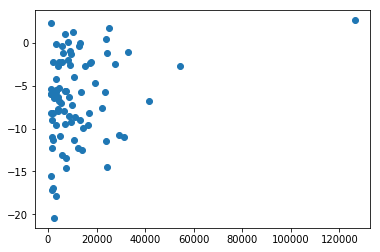

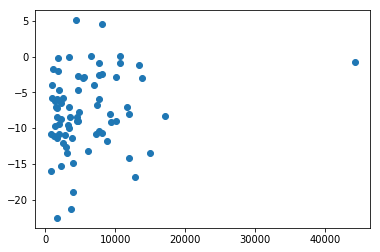

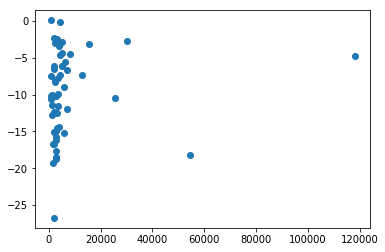

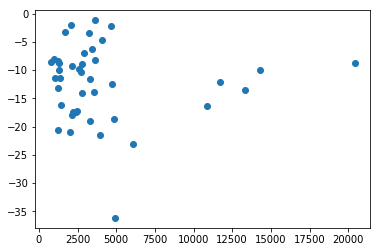

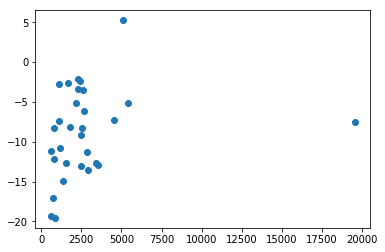

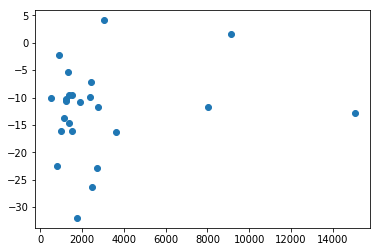

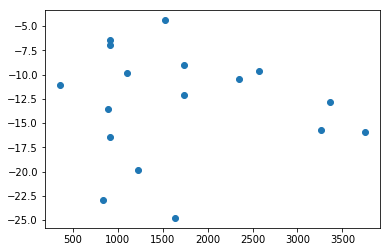

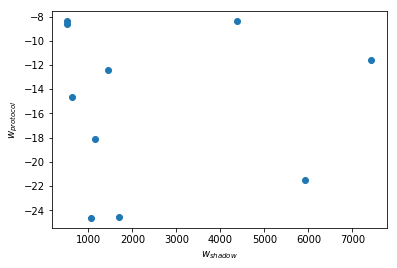

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

for result in results:
    plt.figure()
    plt.scatter(result['w_shads'][1:], result['w_prots'][1:])
plt.xlabel(r'$w_{shadow}$')
plt.ylabel(r'$w_{protocol}$')

In [18]:
for i, result in enumerate(results):
    print(conditions[i])
    print('\t# NaNs: ' + str(int(np.sum(np.isnan(result['w_shads'])))) + '\n')

Condition(timestep=Quantity(value=0.5, unit=femtosecond), switching_time=Quantity(value=1.0, unit=picosecond), n_switching_steps=2000, splitting='BAOAB-end (VRORV-H)')
	# NaNs: 16

Condition(timestep=Quantity(value=1.0, unit=femtosecond), switching_time=Quantity(value=1.0, unit=picosecond), n_switching_steps=1000, splitting='BAOAB-end (VRORV-H)')
	# NaNs: 26

Condition(timestep=Quantity(value=1.5, unit=femtosecond), switching_time=Quantity(value=1.0, unit=picosecond), n_switching_steps=666, splitting='BAOAB-end (VRORV-H)')
	# NaNs: 45

Condition(timestep=Quantity(value=2.0, unit=femtosecond), switching_time=Quantity(value=1.0, unit=picosecond), n_switching_steps=500, splitting='BAOAB-end (VRORV-H)')
	# NaNs: 57

Condition(timestep=Quantity(value=2.5, unit=femtosecond), switching_time=Quantity(value=1.0, unit=picosecond), n_switching_steps=400, splitting='BAOAB-end (VRORV-H)')
	# NaNs: 70

Condition(timestep=Quantity(value=3.0, unit=femtosecond), switching_time=Quantity(value=1.0, unit=

In [19]:
from pymbar import EXP

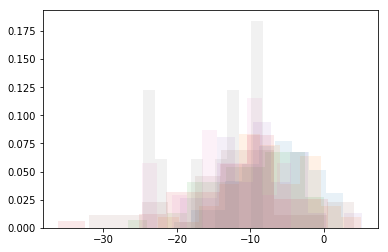

In [30]:
for result in results:
    okay_inds = np.isfinite(result['w_prots'])
    plt.hist(result['w_prots'][okay_inds], histtype='stepfilled', alpha=0.1, normed=True)

In [22]:
means = []
stddevs = []

EXP_estimates = []
EXP_uncs = []
for result in results:
    okay_inds = np.isfinite(result['w_prots'])
    means.append(result['w_prots'][okay_inds].mean())
    stddevs.append(np.std(result['w_prots'][okay_inds]))
    
    EXP_estimate, EXP_unc = EXP(result['w_prots'][okay_inds])
    EXP_estimates.append(EXP_estimate)
    EXP_uncs.append(EXP_unc)

(0, 8.119624022004707)

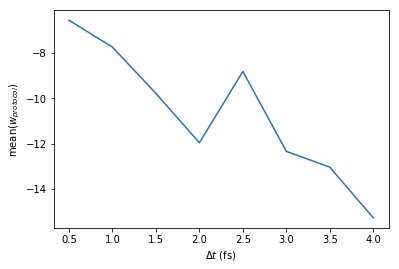

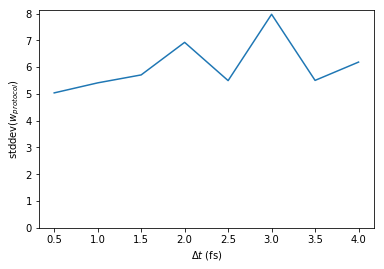

In [24]:
unitless_timesteps = timesteps / unit.femtoseconds
plt.plot(unitless_timesteps, means)
plt.xlabel(r'$\Delta t$ (fs)')
plt.ylabel(r'mean($w_{protocol}$)')

plt.figure()
plt.plot(unitless_timesteps, stddevs)
plt.xlabel(r'$\Delta t$ (fs)')
plt.ylabel(r'stddev($w_{protocol}$)')
plt.ylim(0,)

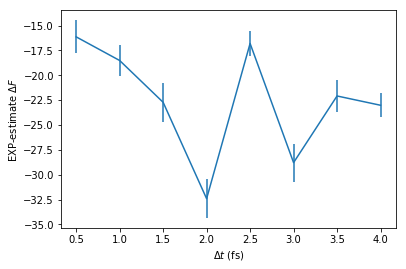

In [27]:
plt.errorbar(unitless_timesteps, EXP_estimates, 1.96 * np.array(EXP_uncs))
plt.xlabel(r'$\Delta t$ (fs)')
plt.ylabel(r'EXP-estimate $\Delta F$')

(0, 18084.03943158399)

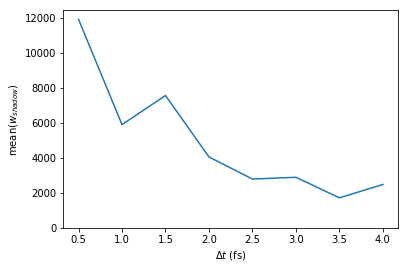

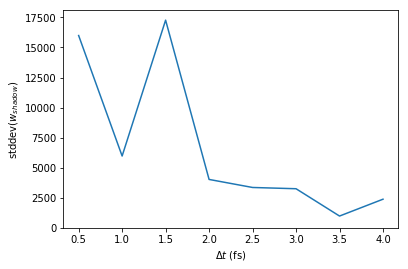

In [29]:
means = []
stddevs = []

for result in results:
    okay_inds = np.isfinite(result['w_shads'])
    means.append(result['w_shads'][okay_inds].mean())
    stddevs.append(np.std(result['w_shads'][okay_inds]))
    
unitless_timesteps = timesteps / unit.femtoseconds
plt.plot(unitless_timesteps, means)
plt.xlabel(r'$\Delta t$ (fs)')
plt.ylabel(r'mean($w_{shadow}$)')
plt.ylim(0,)

plt.figure()
plt.plot(unitless_timesteps, stddevs)
plt.xlabel(r'$\Delta t$ (fs)')
plt.ylabel(r'stddev($w_{shadow}$)')
plt.ylim(0,)